# Kaggle: Cats vs. Dogs

----

### Rough Project Flow

* Separate images into their own directory per class (bash or python)
* Create train/valid/test sets with sub dirs. of 'cats' and 'dogs'
* Create sample set for quick runs
* Train the model using validation for tuning.
    * Re-write the VGG defs. to better grok their underlying structure
    * Fine tune the VGG to this specific problem. Only some weights will be modified.
* Figure out submission. Submission is a set of probabilities for the test image indicies.
    * Will need to:
    * be able to write this csv file in the right forma
    * Apply the built model on test data
    * Submit using the kaggle-cli API

In [35]:
%matplotlib inline

In [36]:
from __future__ import division, print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision = 4, linewidth = 100)
from matplotlib import pyplot as plt

In [37]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

In [38]:
import utils; reload(utils)
from utils import plots

In [1]:
path = "/home/ubuntu/data/dogscats-kaggle/sample/"
#path = "/home/ubuntu/data/dogscats-kaggle/"

In [21]:
batch_size = 4

In [22]:
from vgg16 import Vgg16

The following is pretty black-boxy right now. It appears to read in the images in our train and validation sets. By 'read in' I mean process the images as matrices with the dimensions of their pixels (244 x 244). Each value is a pixel color (0 - 255). Each entry in the batch array contains the image itself as well as 2xn matrix of the true classes. Get batches must pick a directory to be the ones in the first column and the other to be ones in the second column. In a binary classification context their would only need to be one column in the label matrix.

In [59]:
# Initialize a vgg object (now we can call all `vgg.` methods)
vgg = Vgg16()
vgg.classes = ['cat', 'dog']
# Get batches. This function must read in the images and convert them to matricies
batches = vgg.get_batches(path + 'train', batch_size = batch_size)
val_batches = vgg.get_batches(path + 'valid', batch_size = batch_size * 2)
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch = 1)

Found 20 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Epoch 1/1
20/20 [==============================] - 8s - loss: 2.1984 - acc: 0.5000 - val_loss: 1.3423 - val_acc: 0.6000


In [56]:
imgs, labels = next(batches)

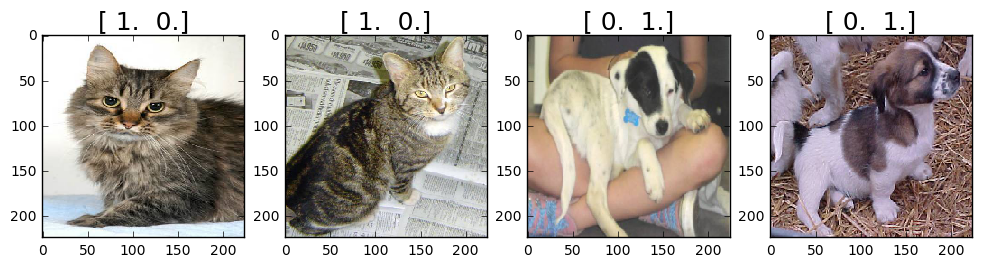

In [57]:
plots(imgs, titles=labels)

In [58]:
vgg.predict(imgs, True)

(array([ 0.9857,  0.6166,  0.8225,  0.606 ], dtype=float32),
 array([0, 0, 0, 0]),
 ['cat', 'cat', 'cat', 'cat'])

In [115]:
classes = ['cat', 'dog']

In [116]:
def ConvBlock(layers, model, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides = (2,2)))

In [117]:
def FCBlock(model):
    model.add(Dense(4096, activation = 'relu'))
    model.add(Dropout(0.5))

In [118]:
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1]

In [119]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape = (3,244,244)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)
    
    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(2, activation = 'softmax'))
    return model

In [120]:
model = VGG_16()

In [98]:
FILES_PATH = "http://www.platform.ai/models/"
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

552796160/553482496 [============================>.] - ETA: 0s

In [99]:
batch_size = 4

In [101]:
def get_batches(dirname, gen = image.ImageDataGenerator(), shuffle = True, 
                batch_size = batch_size, class_mode = 'categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(244,244), 
                                   class_mode = class_mode, shuffle = shuffle, batch_size = batch_size)

In [127]:
batches = get_batches('train', batch_size = batch_size)
val_batches = get_batches('valid', batch_size = batch_size)
imgs,labels = next(batches)

plots(imgs, titles=labels)

Found 20 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


AttributeError: 'Sequential' object has no attribute 'finetune'

In [125]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)
    
    print('Shape: {}'.format(preds.shape))
    print('Classes: {}'.format(classes))
    print('First 5 Probabilities: {}'.format(preds[0, :5]))
    print('Prediction prob/class: ')
    
    for i in range(len(idxs)):
        print(i)
        idx = idxs[i]
        print(' {:.4f}/{}.'.format(preds[i, idx], classes[idx]))

In [126]:
pred_batch(imgs)

Shape: (4, 2)
Classes: ['cat', 'dog']
First 5 Probabilities: [ 0.4859  0.5141]
Prediction prob/class: 
0
 0.5141/dog.
1
 0.5442/dog.
2
 0.5196/dog.
3
 0.5114/cat.


In [121]:
model.predict(imgs).shape

(4, 2)